#### Preparing data
Run the next cells to download and prepare the datasets and util functions.

In [0]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [0]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [ ]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

In [0]:
if download_data:
    unzip_leaf_dataset()

#### Notebook start

In [0]:
import os
import local.lib as lib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from init import dataset_dir
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input, Conv2D,Flatten, LeakyReLU, ReLU, BatchNormalization, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.backend import clear_session

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

# GAN


In [0]:
class GAN():

    def __init__(self, discriminator_model, optimizer_discriminator, generator_model, optimizer_generator, noise_len):

        self.trained = False
        
        self.noise_len = noise_len

        # GAN networks
        self.generator = generator_model
        self.optimizer_generator = optimizer_generator
        self.discriminator = discriminator_model
        self.optimizer_discriminator = optimizer_discriminator
               
        # metrics
        self.loss_metric = 'binary_crossentropy'
        self.performance_metric = 'acc'

        # compile discriminator
        self.discriminator.compile(loss=self.loss_metric, optimizer=self.optimizer_discriminator, metrics=[self.performance_metric])

        # compile generator
        self.generator.compile(loss=self.loss_metric, optimizer=self.optimizer_generator)

        # combining networks
        z = Input(shape=(self.noise_len,))
        img = self.generator(z)

        self.discriminator.trainable = False
        valid = self.discriminator(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss=self.loss_metric, optimizer=self.optimizer_generator)

    def get_batches(self, X, batch_size):

      amount_batches = int(X.shape[0] / batch_size)
      batches = []
      for i in range(amount_batches):
        
        binit = i*batch_size
        bend = (i*batch_size) + batch_size

        batch = X[binit:bend]
        batches.append(batch)
      return batches

    def fit(self, X, epochs=30000, batch_size=32, verbose=0):

        self.epochs = epochs
        self.batch_size = batch_size

        self.trained = False

        # performance
        self.generator_loss = []
        self.discriminator_loss = []
        self.accuracy = []
        
        self.real_accuracy = []
        self.feak_accuracy = []

        self.real_loss = []
        self.feak_loss = []
        
        # Rescale -1 to 1
        X = (X.astype(np.float32) - 127.5) / 127.5
        X = np.expand_dims(X, axis=3)

        for epoch in range(epochs):

            batches = self.get_batches(X, batch_size)

            for n, batch in enumerate(batches):
              
              noise = np.random.normal(0, 1, (batch.shape[0], self.noise_len))
              gen_imgs = self.generator.predict(noise)

              # Train the discriminator with real imgs
              d_loss_real = self.discriminator.train_on_batch(batch, np.ones((batch.shape[0], 1)))
              r_losses, r_accs = d_loss_real
              
              # Train the discriminator with feak imgs
              d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((batch.shape[0], 1)))
              f_losses, f_accs = d_loss_fake
              
              d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

              #  Train Generator
              noise = np.random.normal(0, 1, (batch_size, self.noise_len))

              valid_y = np.array([1] * batch_size)
              g_loss = self.combined.train_on_batch(noise, valid_y)
            
            if verbose:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            self.real_accuracy.append(r_accs)
            self.real_loss.append(r_losses)

            self.feak_accuracy.append(f_accs)
            self.feak_loss.append(f_losses)

            self.generator_loss.append(g_loss)
            self.discriminator_loss.append(d_loss[0])
            self.accuracy.append(d_loss[1])

        self.trained = True

    def generate_fake_imgs(self, n, plot=True, save=False, title=''):

        noise = np.random.normal(0, 1, (n, self.noise_len))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5

        if plot:
            cols = 10
            rows = int(n/cols) +1

            plt.figure(figsize=(30, 8))

            for i in range(n):
                
                plt.subplot(rows, cols, i+1)
                img = gen_imgs[i][:,:,0]
                plt.imshow(img, cmap=plt.get_cmap('binary'))
                plt.title(title)
                
            plt.show()

        if save:
            pass

        return gen_imgs

    def show_performance(self):

        assert self.trained, 'First train the GAN'

        plt.figure(figsize=(10,4))

        plt.subplot(121)
        plt.plot(range(self.epochs), self.generator_loss, label='G loss')
        plt.plot(range(self.epochs), self.discriminator_loss, label='D loss')
        plt.legend()
        plt.grid()
        plt.xlabel('epochs')
        plt.ylabel('loss')

        plt.subplot(122)
        plt.plot(range(self.epochs), self.accuracy, label='accuracy')
        plt.grid()
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend()

In [0]:
split = 1

In [0]:
_, _, X_train, y_train, _, _, _, _, species, num_classes, _, _ = lib.get_splitted_data(data_dir=dataset_dir, check_id_sets=False, use_resize_images=True, split=split)

In [9]:
X_train.shape, y_train.shape

((990, 128, 128), (990,))

In [0]:
img_rows = 128 
img_cols = 128
channels = 1
img_shape = (img_rows, img_cols, channels)

noise_len = 200

epochs = 15
batch_size = 20

In [0]:
d_optimizer = 0
g_optimizer = 0
disc = 0
gene = 0
MGAN = 0

In [12]:
img_shape

(128, 128, 1)

## All classes

In [0]:
def discriminator(img_shape):
  
  model = Sequential()
  model.add(Conv2D(16, kernel_size=7, input_shape=img_shape))
  model.add(LeakyReLU())

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

In [0]:
def generator(img_shape, noise_len):
    
    noise_shape = (noise_len,)
  
    model = Sequential()
    
    model.add(Dense(32*32*256))
    model.add(LeakyReLU())
            
    model.add(Reshape((32,32,256)))
    
    model.add(Conv2DTranspose(256, kernel_size=9, strides=1, padding='same'))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=9, strides=4, padding='same', activation='tanh'))
    
    noise = Input(shape=noise_shape)
    img = model(noise)
    
    return Model(noise, img)

In [0]:
del d_optimizer
del g_optimizer
del disc
del gene
del MGAN

0 [D loss: 10.043531, acc.: 50.00%] [G loss: 223.316727]
1 [D loss: 0.000000, acc.: 100.00%] [G loss: 1598.194092]
2 [D loss: 49.022308, acc.: 10.00%] [G loss: 6.343126]
3 [D loss: 6.408247, acc.: 50.00%] [G loss: 0.096882]
4 [D loss: 6.252333, acc.: 65.00%] [G loss: 9.416324]
5 [D loss: 1.345883, acc.: 55.00%] [G loss: 11.384167]
6 [D loss: 4.234960, acc.: 5.00%] [G loss: 1.822245]
7 [D loss: 0.437649, acc.: 95.00%] [G loss: 1.148996]
8 [D loss: 0.174041, acc.: 100.00%] [G loss: 4.991552]
9 [D loss: 2.717537, acc.: 5.00%] [G loss: 11.037887]
10 [D loss: 20.524784, acc.: 50.00%] [G loss: 33.790840]
11 [D loss: 32.279930, acc.: 50.00%] [G loss: 14.456350]
12 [D loss: 0.463038, acc.: 50.00%] [G loss: 2.079558]
13 [D loss: 0.159357, acc.: 95.00%] [G loss: 9.203081]
14 [D loss: 2.533347, acc.: 50.00%] [G loss: 13.528780]
15 [D loss: 10.619542, acc.: 50.00%] [G loss: 0.002415]
16 [D loss: 8.461621, acc.: 5.00%] [G loss: 13.234202]
17 [D loss: 40.013206, acc.: 0.00%] [G loss: 88.365089]
18 [

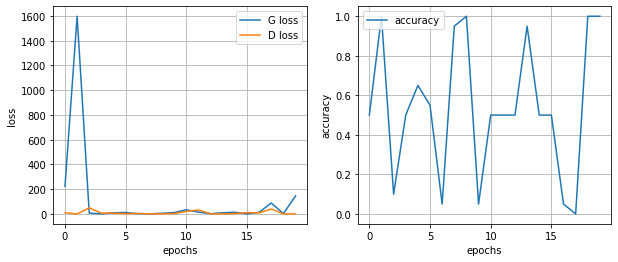

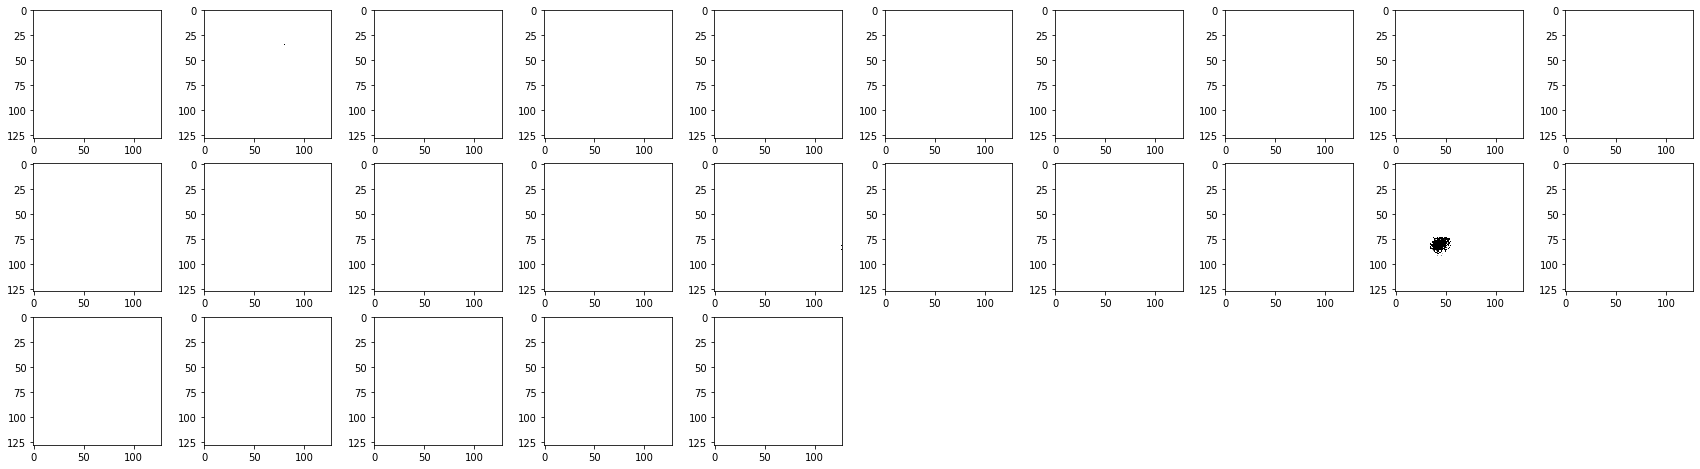

In [16]:
lr = 1e-2
d_optimizer = Adam(lr)
g_optimizer = Adam(1e-3)

disc = discriminator(img_shape=img_shape)
gene = generator(img_shape=img_shape, noise_len=noise_len)

MGAN = GAN(discriminator_model=disc, optimizer_discriminator=d_optimizer,
               generator_model=gene, optimizer_generator=g_optimizer, noise_len=noise_len)

MGAN.fit(X=X_train, epochs=20, batch_size=10, verbose=1)

MGAN.show_performance()
fakes = MGAN.generate_fake_imgs(25, plot=True, save=False)

## One class

In [0]:
n_class = 35

In [0]:
one_class_X_train = X_train[y_train==n_class]

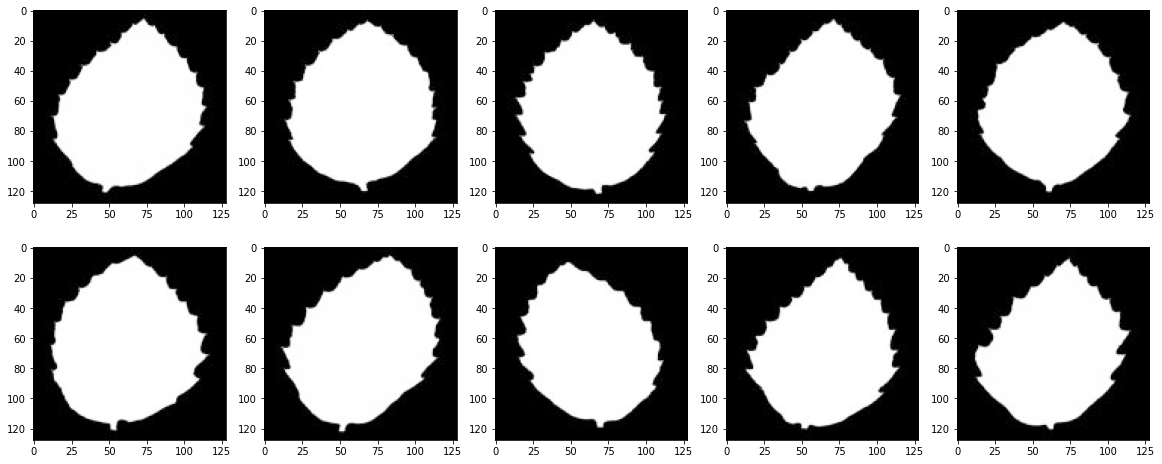

In [19]:
plt.figure(figsize=(20,8))
for i in range(one_class_X_train.shape[0]):
  plt.subplot(2,5,i+1)
  plt.imshow(one_class_X_train[i], cmap="Greys_r")

In [20]:
one_class_X_train.shape

(10, 128, 128)

In [0]:
d_optimizer = 0
g_optimizer = 0
disc = 0
gene = 0
MGAN = 0

In [0]:
def discriminator(img_shape):
  
  model = Sequential()
  model.add(Conv2D(16, kernel_size=7, input_shape=img_shape))
  model.add(LeakyReLU())

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

In [0]:
def generator(img_shape, noise_len):
    
    noise_shape = (noise_len,)
  
    model = Sequential()

    model.add(Dense(32))
    model.add(LeakyReLU())
    
    model.add(Dense(32*32*128))
    model.add(LeakyReLU())
            
    model.add(Reshape((32,32,128)))
    
    model.add(Conv2DTranspose(128, kernel_size=9, strides=1, padding='same'))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, kernel_size=9, strides=1, padding='same'))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=9, strides=4, padding='same', activation='tanh'))
    
    noise = Input(shape=noise_shape)
    img = model(noise)
    
    return Model(noise, img)

In [ ]:
del d_optimizer
del g_optimizer
del disc
del gene
del MGAN

0 [D loss: 0.358502, acc.: 50.00%] [G loss: 25.015314]
1 [D loss: 0.000000, acc.: 100.00%] [G loss: 84.689232]
2 [D loss: 156.079803, acc.: 50.00%] [G loss: 0.001005]
3 [D loss: 20.069704, acc.: 50.00%] [G loss: 0.000000]
4 [D loss: 30.288595, acc.: 50.00%] [G loss: 0.000000]
5 [D loss: 27.702549, acc.: 50.00%] [G loss: 0.000000]
6 [D loss: 16.752605, acc.: 50.00%] [G loss: 0.000000]
7 [D loss: 0.000631, acc.: 100.00%] [G loss: 34.223366]
8 [D loss: 927.097351, acc.: 50.00%] [G loss: 0.000000]
9 [D loss: 839.823364, acc.: 50.00%] [G loss: 0.000000]
10 [D loss: 654.572693, acc.: 50.00%] [G loss: 0.000000]
11 [D loss: 399.210266, acc.: 50.00%] [G loss: 0.000000]
12 [D loss: 78.076866, acc.: 50.00%] [G loss: 253.716064]
13 [D loss: 54.412769, acc.: 50.00%] [G loss: 0.000000]
14 [D loss: 89.532593, acc.: 50.00%] [G loss: 0.000000]
15 [D loss: 135.996140, acc.: 50.00%] [G loss: 0.000000]
16 [D loss: 118.691628, acc.: 50.00%] [G loss: 0.000000]
17 [D loss: 53.502861, acc.: 50.00%] [G loss: 0

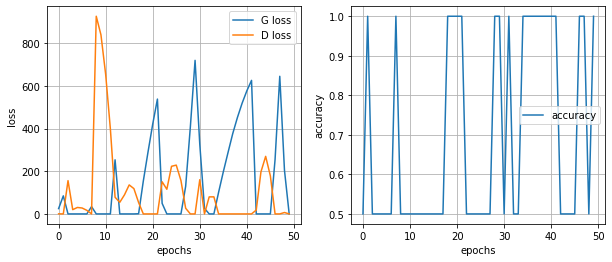

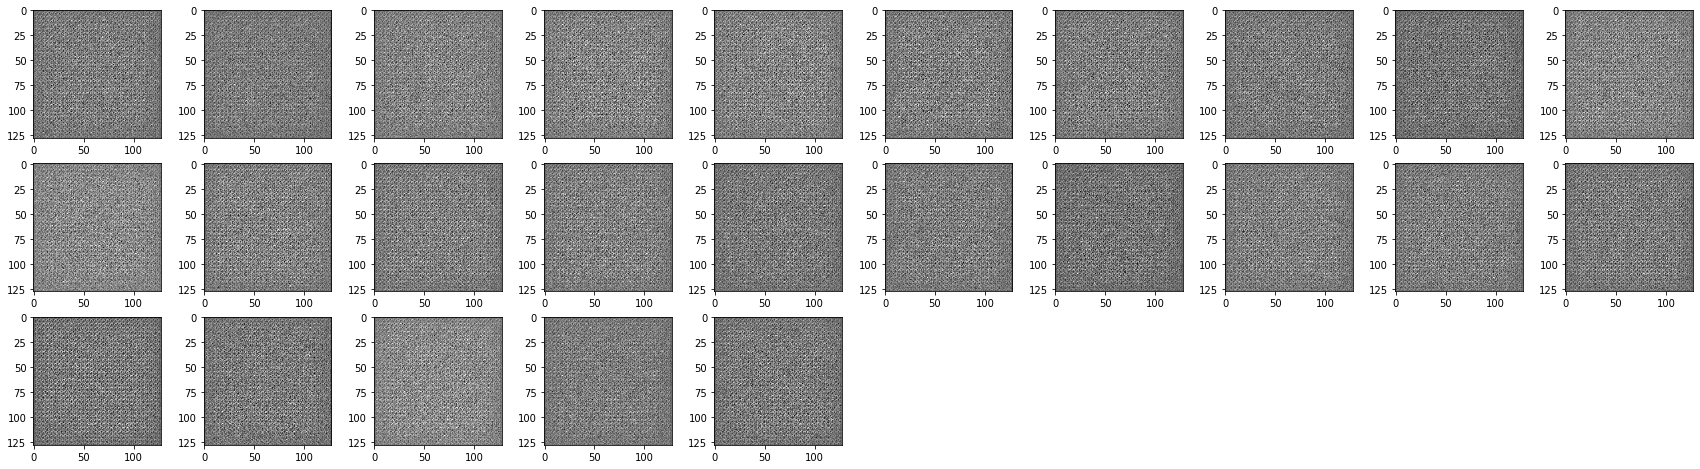

In [26]:
lr = 1e-2
d_optimizer = Adam(lr)
g_optimizer = SGD(1e-5)

disc = discriminator(img_shape=img_shape)
gene = generator(img_shape=img_shape, noise_len=noise_len)

MGAN = GAN(discriminator_model=disc, optimizer_discriminator=d_optimizer,
               generator_model=gene, optimizer_generator=g_optimizer, noise_len=noise_len)

MGAN.fit(X=one_class_X_train, epochs=50, batch_size=10, verbose=1)

MGAN.show_performance()
fakes = MGAN.generate_fake_imgs(25, plot=True, save=False)